# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

In [25]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

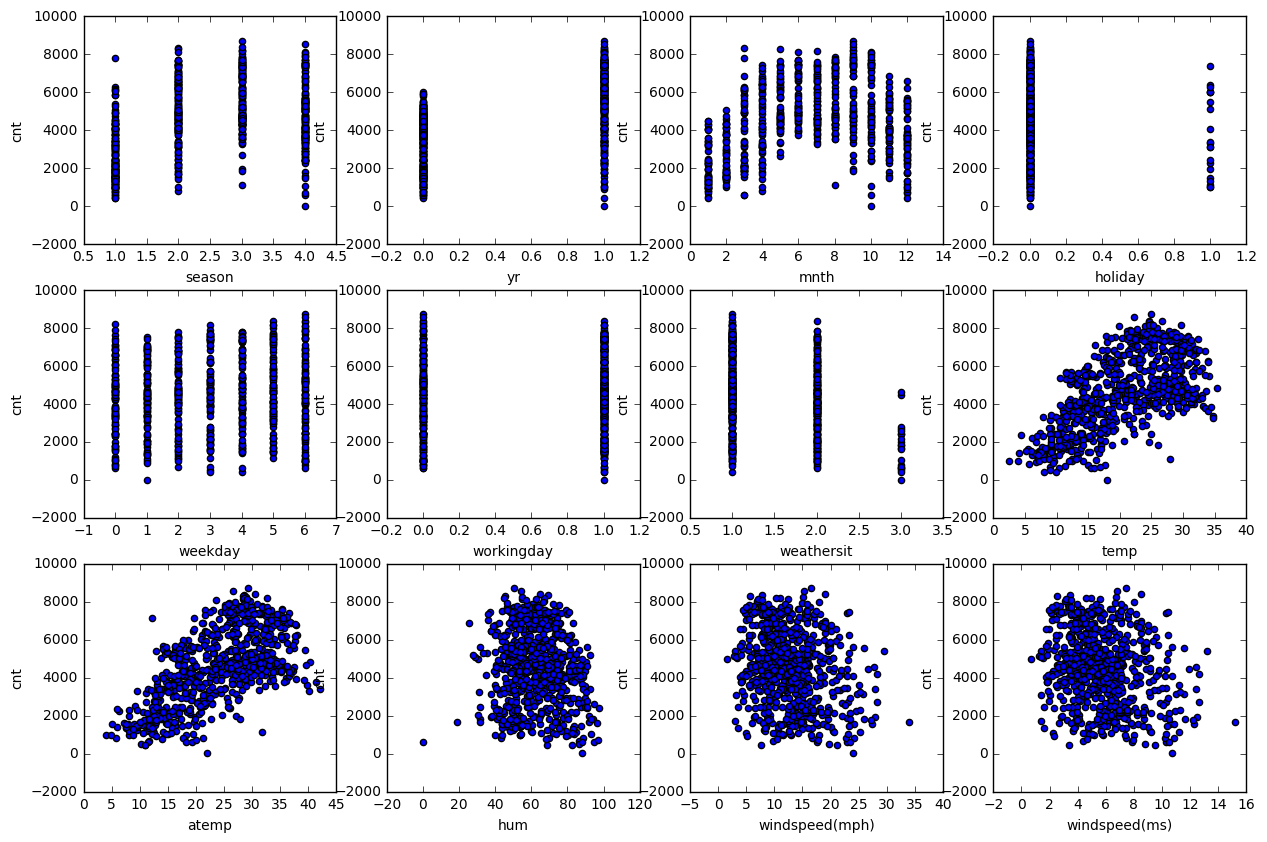

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [27]:
df[df.columns[:-1]].corrwith(df[df.columns[-1]])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [28]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [29]:
df[df.columns[:-1]].mean()

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [30]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [31]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
print zip(linear_regressor.coef_, df.columns)

[(570.86953733930841, 'season'), (1021.9735701681132, 'yr'), (-141.30509701551961, 'mnth'), (-86.760600506732132, 'holiday'), (137.22605600649237, 'weekday'), (56.390296649445418, 'workingday'), (-330.22947173533521, 'weathersit'), (367.48614063800244, 'temp'), (585.54295805691061, 'atemp'), (-145.60910865708706, 'hum'), (12458424740010.082, 'windspeed(mph)'), (-12458424740208.541, 'windspeed(ms)')]


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

In [34]:
from sklearn.linear_model import Lasso, Ridge

In [35]:
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
print zip(lasso_regressor.coef_, df.columns)

[(560.24161603088692, 'season'), (1019.4634940657196, 'yr'), (-128.7306270367875, 'mnth'), (-86.152781333711104, 'holiday'), (137.34789390496312, 'weekday'), (55.212370641356721, 'workingday'), (-332.36985696234859, 'weathersit'), (376.3632362096987, 'temp'), (576.53079350455096, 'atemp'), (-144.12915500348606, 'hum'), (-197.1396894024858, 'windspeed(mph)'), (-2.8049811945715987e-08, 'windspeed(ms)')]


In [36]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
print zip(ridge_regressor.coef_, df.columns)

[(563.0645722520145, 'season'), (1018.9483787875297, 'yr'), (-131.87332028247451, 'mnth'), (-86.746097997092761, 'holiday'), (138.00511117871881, 'weekday'), (55.903110375064529, 'workingday'), (-332.34978849907293, 'weathersit'), (386.45788919196326, 'temp'), (566.34704706001207, 'atemp'), (-145.07132729867237, 'hum'), (-99.259441081818409, 'windspeed(mph)'), (-99.259441154315908, 'windspeed(ms)')]


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [37]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for idx, alp in enumerate(alphas):
    lasso_regressor = Lasso(alpha = alp)
    lasso_regressor.fit(X, y)
    coefs_lasso[idx] = lasso_regressor.coef_
    ridge_regressor = Ridge(alpha = alp)
    ridge_regressor.fit(X, y)
    coefs_ridge[idx] = ridge_regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

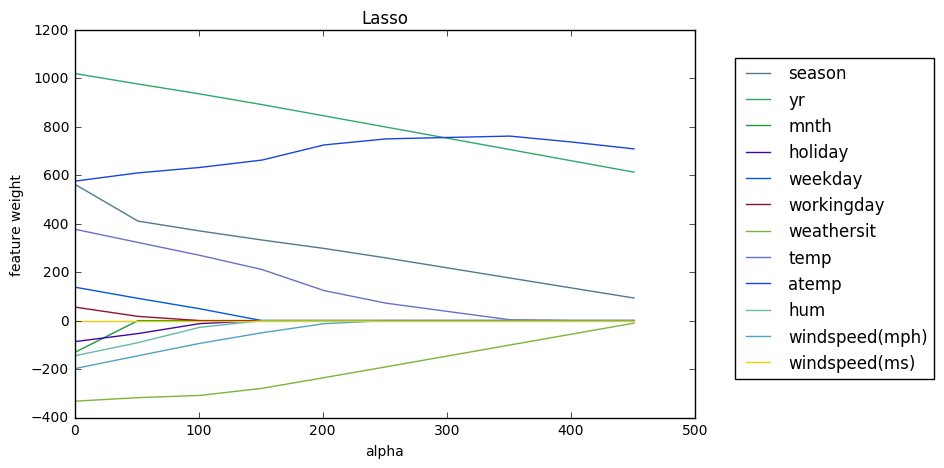

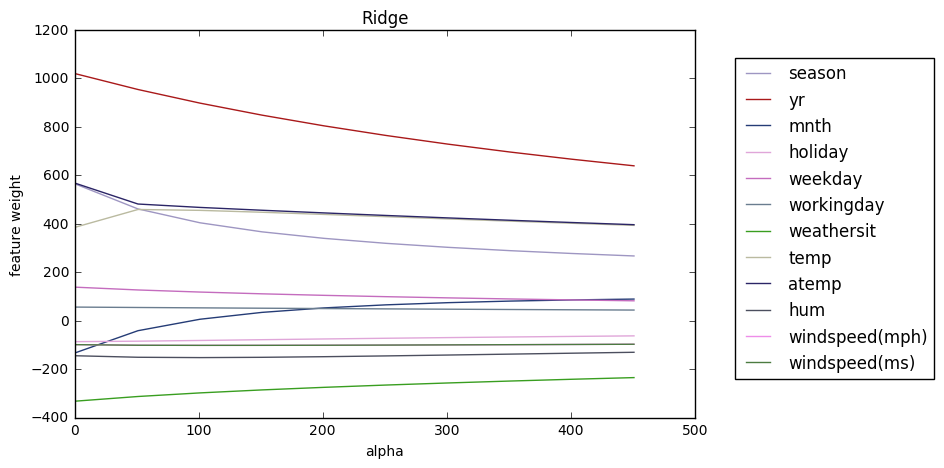

In [38]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [39]:
print coefs_lasso[:, -1]
print coefs_ridge[:, -1]
print coefs_lasso[:, 2]
print coefs_ridge[:, 2]

[ -2.80498119e-08  -2.29881243e-08  -2.41647790e-08  -2.62767775e-08
  -2.78781252e-08  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00]
[ -99.25944115 -101.62731483 -102.10167084 -102.00537593 -101.58638458
 -100.96471143 -100.20862041  -99.36066117  -98.44906427  -97.49343362]
[-128.73062704   -0.            0.            0.            0.            0.
    0.            0.            0.            0.        ]
[-131.87332028  -41.56545001    5.67424346   34.02728278   52.48987295
   65.15200737   74.13828141   80.660457     85.45925409   89.01232285]


По графикам видно, что наклон кривых Lasso при фиксированном alpha в большинстве случаев больше, чем кривых Ridge, то есть регуляризатор Lasso агрессивнее уменьшает веса. 
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: веса стремятся к нулю, модель стремится к константной. 
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Да, lasso исключает признак пр любом значении alpha. Ridge не исключает данный признак. (См. вывод двух последний столбцов из матриц с коэффициентами).   
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso, т.к. он зануляет веса при неинформативных признаках. 

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [40]:
from sklearn.linear_model import LassoCV

Пары коэффициент-признак: [(532.01898284135348, 'season'), (1015.0602226430601, 'yr'), (-100.03952614356631, 'mnth'), (-83.293959875299223, 'holiday'), (132.50446549095798, 'weekday'), (51.557085614073792, 'workingday'), (-330.55985673998146, 'weathersit'), (370.67985503003541, 'temp'), (581.39693106549646, 'atemp'), (-140.00740550068858, 'hum'), (-191.7714084713507, 'windspeed(mph)'), (-2.6854541815693778e-08, 'windspeed(ms)')]
Выбранное alpha: 6


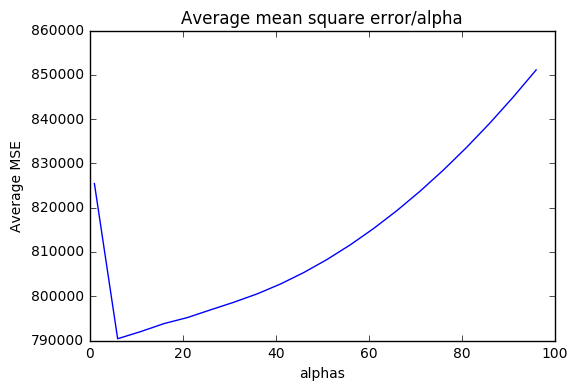

In [41]:
# Обучим регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведем выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lassocv_regressor = LassoCV(alphas = alphas)
lassocv_regressor.fit(X, y)
print 'Пары коэффициент-признак:', zip(lassocv_regressor.coef_, df.columns)
print 'Выбранное alpha:', lassocv_regressor.alpha_
plt.figure()
plt.xlabel('alphas')
plt.ylabel('Average MSE')
plt.title('Average mean square error/alpha')
plt.plot(lassocv_regressor.alphas_, np.mean(lassocv_regressor.mse_path_, axis = 1))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [42]:
lassocv_regressor.mse_path_

array([[ 863936.50981215,  826364.11936907,  862993.29751896],
       [ 860479.31511365,  821110.1817776 ,  853075.13780625],
       [ 857344.83606082,  816153.27782428,  843628.81286098],
       [ 854526.73639431,  811496.34805693,  834654.45357262],
       [ 852024.62341384,  807139.39657173,  826152.16399015],
       [ 849838.18755425,  803082.42338526,  818122.01934907],
       [ 847967.16232762,  799325.42849761,  810564.07404745],
       [ 846411.31812808,  795868.41190876,  803478.3674151 ],
       [ 845170.45707972,  792711.37361871,  796864.92788593],
       [ 844244.40861679,  789854.31362747,  790723.77601555],
       [ 843633.02568868,  787297.23193504,  785058.69560905],
       [ 843336.18149882,  785040.12854141,  779861.12465128],
       [ 843353.76670095,  783083.00344659,  775139.90236011],
       [ 843616.44582031,  781425.85665058,  770886.43550572],
       [ 843608.19759457,  780068.68815337,  767109.44006007],
       [ 844145.56423514,  777586.36117475,  763800.364

Значения alpha, соответствующие минимумам MSE на каждом разбиении [41  6  1]


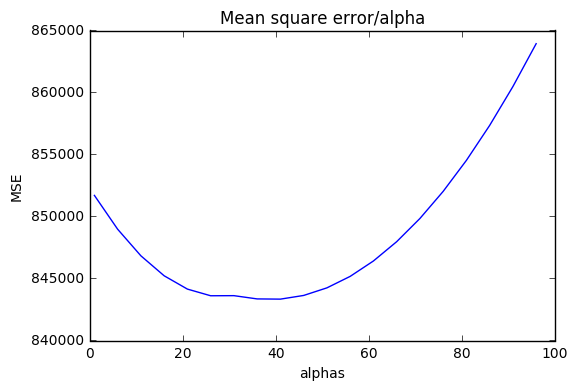

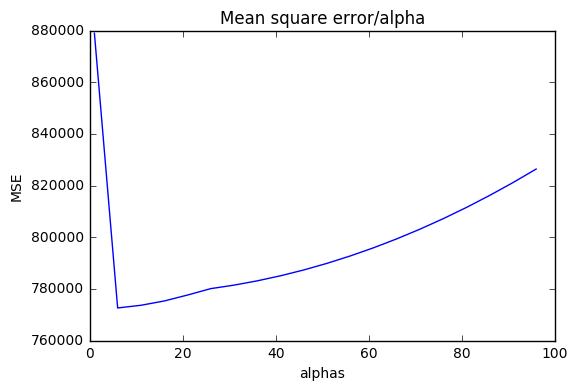

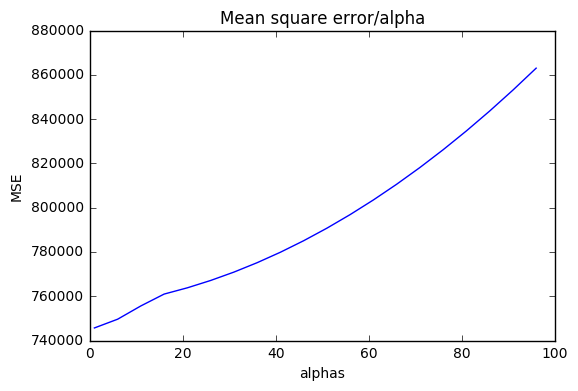

In [43]:
# Выведе значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируем столбцы .mse_path_
print 'Значения alpha, соответствующие минимумам MSE на каждом разбиении', lassocv_regressor.alphas_[np.argmin(lassocv_regressor.mse_path_, axis = 0)]
lassocv_regressor.mse_path_[:, 0]
plt.figure()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.title('Mean square error/alpha')
plt.plot(lassocv_regressor.alphas_, lassocv_regressor.mse_path_[:, 0])
plt.figure()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.title('Mean square error/alpha')
plt.plot(lassocv_regressor.alphas_, lassocv_regressor.mse_path_[:, 1])
plt.figure()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.title('Mean square error/alpha')
plt.plot(lassocv_regressor.alphas_, lassocv_regressor.mse_path_[:, 2])

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

In [44]:
print 'Коэффициенты: ', lassocv_regressor.coef_
print 'Значения 4 наибольших весов:', lassocv_regressor.coef_[np.argpartition(-lassocv_regressor.coef_, 4)[:4]]
print 'Индексы соответствущих признаков:', np.argpartition(-lassocv_regressor.coef_, 4)[:4]
print zip (lassocv_regressor.coef_[np.argpartition(-lassocv_regressor.coef_, 4)[:4]], df.columns[np.argpartition(-lassocv_regressor.coef_, 4)[:4]])

Коэффициенты:  [  5.32018983e+02   1.01506022e+03  -1.00039526e+02  -8.32939599e+01
   1.32504465e+02   5.15570856e+01  -3.30559857e+02   3.70679855e+02
   5.81396931e+02  -1.40007406e+02  -1.91771408e+02  -2.68545418e-08]
Значения 4 наибольших весов: [ 1015.06022264   581.39693107   532.01898284   370.67985503]
Индексы соответствущих признаков: [1 8 0 7]
[(1015.0602226430601, 'yr'), (581.39693106549646, 'atemp'), (532.01898284135348, 'season'), (370.67985503003541, 'temp')]


In [45]:
print 'Коэффициенты: ', lassocv_regressor.coef_
print 'Значения 3 наименьших весов:', lassocv_regressor.coef_[np.argpartition(lassocv_regressor.coef_, 3)[:3]]
print 'Индексы соответствущих признаков:', np.argpartition(lassocv_regressor.coef_, 3)[:3]
print zip (lassocv_regressor.coef_[np.argpartition(lassocv_regressor.coef_, 3)[:3]], df.columns[np.argpartition(lassocv_regressor.coef_, 3)[:3]])

Коэффициенты:  [  5.32018983e+02   1.01506022e+03  -1.00039526e+02  -8.32939599e+01
   1.32504465e+02   5.15570856e+01  -3.30559857e+02   3.70679855e+02
   5.81396931e+02  -1.40007406e+02  -1.91771408e+02  -2.68545418e-08]
Значения 3 наименьших весов: [-191.77140847 -330.55985674 -140.0074055 ]
Индексы соответствущих признаков: [10  6  9]
[(-191.7714084713507, 'windspeed(mph)'), (-330.55985673998146, 'weathersit'), (-140.00740550068858, 'hum')]


Признаки year, season, temp, atemp. В признаке year можно заключить, что во второй год велосипедов в среднем брали больше. Season: кроме зимы видна линейная зависимость. Atemp и temp есть линейная возрастающая зависимость. Из здравого смысла логично утверждать, что рост значения atemp и temp должен приводить к росту cnt. Year влиять не должен. Season зависит от места, ге бралсь статистика (смотря какая погода там в это время). 

Ситуация с погодой, влажность и скорость ветра. Четкая убывающая линейная зависимость видна только в признаке weathersit (слабо видна в hum). Чем хуже погода (больше значение weathersit), тем меньше берут велосипеды - логично. Чем больше ветер, тем меньше берут велосипеды - логично. Чем больше влажность, тем меньше берут велосипеды - логично.  

Признак windspeed (ms) имеет коэффициент -2.68545418e-08. Это логично, т.к. имеется признак windspeed(mph), который содержит в себе ту же информацию и модель его исключила. Графики windspeed (ms) и windspeed(ms) абсолютно идентичны. Неверно, на спрос этот признак влияет, но это влияние учтено в другом признаке. 

In [46]:
print 'Коэффициенты: ', lassocv_regressor.coef_

Коэффициенты:  [  5.32018983e+02   1.01506022e+03  -1.00039526e+02  -8.32939599e+01
   1.32504465e+02   5.15570856e+01  -3.30559857e+02   3.70679855e+02
   5.81396931e+02  -1.40007406e+02  -1.91771408e+02  -2.68545418e-08]


### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.